In [5]:
import SimpleITK as sitk
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import cv2
import time
import glob
import json
import imageio

In [2]:
from data_processor import voxel2world_coord, world2voxel_coord, resize, hu2gray, interpolate_volume, generate_gaussian_mask_3d, compute_gaussian_radius
from make_db import read_annotations, read_bboxes, scale2newspacing
from data_generator import DataGenerator
from config import cfg
from utils import resize_same_shape

In [3]:
data_path1 = '/home/jxw/Downloads/jiaotong_test/multi/'
data_path2 = '/home/jxw/Downloads/jiaotong_test/solitary/'
data_path3 = '/home/jxw/Downloads/mediastinal_1/annoation/'

In [4]:
list1 = os.listdir(data_path1)

In [5]:
list2 = os.listdir(data_path2)

In [6]:
list3 = os.listdir(data_path3)

In [13]:
result = {}
new_spacing = (1, 1, 1)
for data in tqdm(list1):
    data_name = os.path.join(data_path1, data, data+'.nii')
    if not os.path.exists(data_name):
        print(data)
        continue
    raw_data = sitk.ReadImage(data_name)
    org_spacing = raw_data.GetSpacing()
    W, H, D = raw_data.GetSize()
    scale = np.array(org_spacing) / np.array(new_spacing)
    nW, nH, nD = np.int32(np.array([W, H, D]) * scale)
    result[data] = [nD, nH, nW]


100%|██████████| 13/13 [00:14<00:00,  1.74s/it]

In [17]:
for data in tqdm(list3):
    data_name = os.path.join(data_path3, data, data+'.nii')
    if not os.path.exists(data_name):
        print(data)
        continue
    raw_data = sitk.ReadImage(data_name)
    org_spacing = raw_data.GetSpacing()
    W, H, D = raw_data.GetSize()
    scale = np.array(org_spacing) / np.array(new_spacing)
    nW, nH, nD = np.int32(np.array([W, H, D]) * scale)
    result[data] = [nD, nH, nW]


 33%|███▎      | 309/940 [09:47<18:05,  1.72s/it]


 62%|██████▏   | 580/940 [19:02<12:16,  2.05s/it]

annoation_128_train.json



 68%|██████▊   | 635/940 [20:44<10:32,  2.07s/it]

annoation_128_test.json



 86%|████████▌ | 805/940 [26:02<04:10,  1.86s/it]

annoation_128.json



100%|██████████| 940/940 [31:07<00:00,  1.71s/it]

In [11]:
D, H, W = raw_data.GetSize()

In [25]:
for key in result.keys():
    result[key] = [float(i) for i in result[key]]

In [38]:
with open('results/lesion_size.json', 'w') as f:
    json.dump(lesion_size, f)

In [4]:
train_path = './results/train_single_torch.json'
test_path1 = './results/test_single_torch.json'
test_path2 = './results/test_multi_torch.json'

In [35]:
# lesion_size = {}
with open(train_path, 'r') as f:
    detect_res = json.load(f)
    for key in detect_res.keys():
#         now = {}
        temp = np.array(detect_res[key]['bbox_gt'])[:, 3:] * np.array(result[key])
        lesion_size[key] = temp.tolist()

In [37]:
len(lesion_size.keys())

1136

In [33]:
res = []
for key in lesion_size.keys():
    res.append(np.array(lesion_size[key]))

In [34]:
res = np.vstack(res)

In [44]:
size = np.mean(res, axis=1)

In [67]:
(size // 10).astype(np.int)

array([2, 2, 4, ..., 6, 3, 3])

In [77]:
a = np.sum(size < 30)
b = np.sum(size < 50)
c = np.sum(size < 70)
d = np.sum(size < 100)
# e = np.sum(size < 100)

In [75]:
a = np.sum(size < 20)
b = np.sum(size < 40)
c = np.sum(size < 60)
d = np.sum(size < 80)
e = np.sum(size < 100)

In [78]:
print(a, b-a, c-b, d-c, 1152-d)

358 366 236 119 73


In [74]:
np.max(size)

204.7707833929932

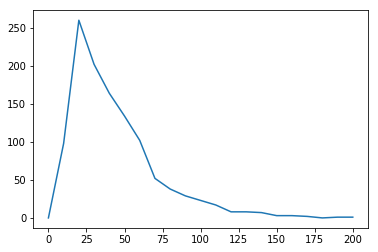

In [73]:
plt.plot(np.arange(0, 210, 10), np.bincount((size // 10).astype(np.int)))

In [50]:
np.min(size)

10.969315

In [3]:
with open('./results/lesion_size.json', 'r') as f:
    lesion_size = json.load(f)

In [6]:
with open(train_path, 'r') as f:
    train = json.load(f)

In [8]:
train_names = list(train.keys())

In [29]:
from sklearn.model_selection import KFold
res = KFold(n_splits=5)

In [21]:
np.random.shuffle(train_names)

In [22]:
train_names

['0723089',
 '0314838',
 '0926925',
 '0317681',
 '0418708',
 '0411032',
 '0441002',
 '0987035',
 '0506585',
 '1030240',
 '0329727',
 '0899494',
 '0628962',
 '0529390',
 '1047648',
 '0521447',
 '1005868',
 '0584472',
 '0468025',
 '0765356',
 '0565799',
 '0397965',
 '0518186',
 '0466374',
 '0586864',
 '0689626',
 '0891358',
 '0602737',
 '0996588',
 '0555130',
 '1012352',
 '1024395',
 '0561675',
 '0513223',
 '1054058',
 '0753072',
 '0270655',
 '0397720',
 '0362439',
 '0405442',
 '0760277',
 '0695130',
 '0459887',
 '0906707',
 '0457342',
 '0532388',
 '0560176',
 '0911131',
 '0414924',
 '0940910',
 '0417111',
 '0359224',
 '0646601',
 '0613060',
 '0401926',
 '0255426',
 '0425769',
 '0629808',
 '0501259',
 '0483228',
 '0865658',
 '0576123',
 '0692029',
 '0775636',
 '0420652',
 '0575470',
 '1001955',
 '0835187',
 '1082763',
 '0651037',
 '1084117',
 '0398752',
 '0463298',
 '0685289',
 '0602198',
 '0739659',
 '0894029',
 '1061826',
 '0517841',
 '0761049',
 '0610880',
 '0957222',
 '0581949',
 '03

In [30]:
cv = {}
for k, (train, test) in enumerate(res.split(train_names)):
    fold = {}
    print(k, len(train), len(test))
    train_list = []
    val_list = []
    for i in train:
        train_list.append(train_names[i])
    for i in test:
        val_list.append(train_names[i])
    fold['train'] = train_list
    fold['val'] = val_list 
    cv['fold%d' % k] = fold
    

0 748 188
1 749 187
2 749 187
3 749 187
4 749 187


In [31]:
with open('./results/kflod5.json', 'w') as f:
    json.dump(cv, f)

In [36]:
maxsize = np.max(res, axis=1)
minsize = np.min(res, axis=1)

In [42]:
np.max(maxsize / minsize)

2.8833897829081856

In [41]:
np.min(minsize)

8.51739

In [8]:
label_file = '/home/jxw/Downloads/mediastinal_1/mediastinal_label_1.xlsx'
with open(train_path, 'r') as f:
    train_res = json.load(f)
labels = pd.read_excel(label_file)
for k in tqdm(range(len(labels))):
    name = '%07d' % labels['ID'].iloc[k]
    label = labels['label_1'].iloc[k]
    if name not in train_res:
        continue
    img = np.load(os.path.join(data_path3, name, name + '_.npy'))
    img = hu2gray(img, WL=40, WW=500)
    w, h, t = img.shape
    bbox_gt = np.array(train_res[name]['bbox_gt']) * np.array([w, h, t, w, h, t])
    size = np.mean(bbox_gt[0, 3:])
    if size < 30:
        out_path = './results/img1/0/'
    elif size < 50:
        out_path = './results/img1/30/'
    elif size < 70:
        out_path = './results/img1/50/'
    elif size < 100:
        out_path = './results/img1/70/'
    elif size >= 100:
        out_path = './results/img1/100/'
        
    for i in range(bbox_gt.shape[0]):
        a, b = int(bbox_gt[i, 1] - bbox_gt[i, 4] / 2), int(bbox_gt[i, 2] - bbox_gt[i, 5] / 2)
        c, d = int(bbox_gt[i, 1] + bbox_gt[i, 4] / 2), int(bbox_gt[i, 2] + bbox_gt[i, 5] / 2)
        for j in range(int(bbox_gt[i, 0] - bbox_gt[i, 3] / 2), int(bbox_gt[i, 0] + bbox_gt[i, 3] / 2)+1):
            vis_im = np.zeros((h, t, 3))
            # print(vis_im.shape)
            vis_im[..., 0] = img[j, :, :]
            vis_im[..., 1] = img[j, :, :]
            vis_im[..., 2] = img[j, :, :]
            cv2.rectangle(vis_im, (b, a), (d, c), (0, 255, 0), 2)
            imageio.imsave(os.path.join(out_path, '{}_{}_{}.png'.format(name, label, j)), np.uint8(vis_im))


 12%|█▏        | 109/937 [08:54<1:29:19,  6.47s/it]

IndexError: index 363 is out of bounds for axis 0 with size 363

In [6]:
results = resize_same_shape(data_path1, list1)

100%|██████████| 13/13 [00:42<00:00,  3.84s/it]


In [8]:
results2 = resize_same_shape(data_path2, list2)

100%|██████████| 187/187 [10:38<00:00,  3.32s/it]


In [10]:
results.update(results2)

In [11]:
len(results.keys())

200

In [12]:
with open('/home/jxw/Downloads/jiaotong_test/annoation_128.json', 'w') as f:
    json.dump(results, f)

In [48]:
data_path = '/home/jxw/Downloads/mediastinal_1/annoation/'

In [2]:
label_file = '/home/jxw/Downloads/mediastinal_1/mediastinal_label_1.xlsx'

In [49]:
list2 = os.listdir(data_path)

In [9]:
len(list2)

187

In [53]:
for lt in list1:
    if lt not in list2:
        print(lt)

annoation_192.csv
annoation_raw.csv
annoation.csv
annoation_128.csv


In [3]:
data = DataGenerator(cfg)

loading annotations from  ./data/jiaotong_200/annoation/annoation_128.csv
load annotation done
found train images: 190
found test images: 10


In [14]:
for i in tqdm(range(1000)):
    im, cnt_gt, sze_gt = data.next_batch(1)
    if np.where(sze_gt != 0)[0].shape[0] == 0:
        print('error')

 45%|████▍     | 446/1000 [00:54<00:55,  9.99it/s]

KeyboardInterrupt: 

In [15]:
im.shape

(1, 128, 96, 128, 1)

In [18]:
np.where(sze_gt !=0 )

(array([0, 0, 0]),
 array([78, 78, 78]),
 array([24, 24, 24]),
 array([65, 65, 65]),
 array([0, 1, 2]))

In [58]:
sze_gt[0, 86, 50, 65]

array([0., 0., 0.])

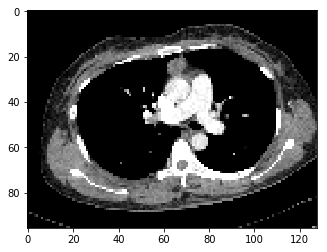

In [20]:
plt.imshow(im[0, 78, :, :, 0], 'gray')

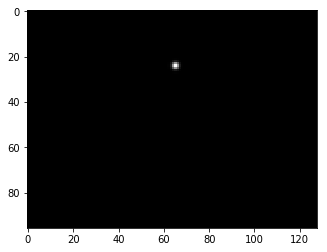

In [21]:
plt.imshow(cnt_gt[0, 78, :, :, 0], 'gray')

In [4]:
data_names = os.listdir(data_path)

In [5]:
len(data_names)

203

In [38]:
bboxs = pd.read_csv(os.path.join(data_path, 'annoation_128.csv'), index_col='name')

In [71]:
with open(os.path.join(data_path, 'annoation_128.json'), 'r') as f:
    anno = json.load(f)

In [60]:
key = list(anno.keys())

In [64]:
idx = np.random.choice(np.arange(0, 936), 20)

In [65]:
test_keys = [key[i] for i in idx]

In [73]:
test_anno = {}

In [74]:
for test_key in test_keys:
    test_anno[test_key] = anno.pop(test_key)

In [75]:
len(test_anno.keys())

20

In [76]:
len(anno.keys())

916

In [78]:
with open(os.path.join(data_path, 'annoation_128_train.json'), 'w') as f:
    json.dump(anno, f)
with open(os.path.join(data_path, 'annoation_128_test.json'), 'w') as f:
    json.dump(test_anno, f)

In [39]:
bboxs.index

Int64Index([271871, 591127, 561675, 594243, 776465, 638924, 491901, 365210,
            463753, 333025,
            ...
            451016, 530264, 641516, 600339, 276205, 568197, 708791, 510525,
            740102, 379883],
           dtype='int64', name='name', length=200)

In [40]:
results = {}
for idx in bboxs.index.values:
    x, y, z, w, h, d, flag = bboxs.loc[idx]
    filename = '0' + str(idx)
    results[filename] = {
        'x': x,
        'y': y,
        'z': z,
        'w': w,
        'h': h, 
        'd': d,
        'train': flag,
    }

In [41]:
results

{'0271871': {'x': 44.40816326530612,
  'y': 45.0,
  'z': 91.75,
  'w': 18.82454204081633,
  'h': 15.6882432,
  'd': 15.0330624,
  'train': 1.0},
 '0591127': {'x': 97.36964980544748,
  'y': 50.0,
  'z': 57.5,
  'w': 35.84951024271484,
  'h': 26.208880201511327,
  'd': 23.21660130982368,
  'train': 1.0},
 '0561675': {'x': 99.08880308880308,
  'y': 48.75,
  'z': 56.75,
  'w': 11.97370007972484,
  'h': 9.405688452088453,
  'd': 13.752257100737099,
  'train': 1.0},
 '0594243': {'x': 87.09885057471264,
  'y': 45.0,
  'z': 59.0,
  'w': 9.68605750508815,
  'h': 9.511156869565216,
  'd': 10.109373217391305,
  'train': 1.0},
 '0776465': {'x': 95.6810631229236,
  'y': 43.75,
  'z': 68.5,
  'w': 15.253819534883725,
  'h': 11.284268429752064,
  'd': 11.047976198347108,
  'train': 1.0},
 '0638924': {'x': 96.96969696969695,
  'y': 55.25,
  'z': 80.75,
  'w': 23.098584605238692,
  'h': 22.056876065573764,
  'd': 21.045938360655747,
  'train': 1.0},
 '0491901': {'x': 89.97732426303854,
  'y': 44.75,
  

In [14]:
box = bboxs.iloc[0]

In [21]:
np.array(box[:6], dtype=np.int)

array([ 66,  67, 137,  28,  23,  22])

In [22]:
bboxs.to_csv(os.path.join(data_path, 'annoation.csv'), index='name')

In [36]:
bboxs['name'] = bboxs['name'].apply(lambda x: '0' + str(x))

KeyError: 'name'

In [27]:
bboxs = bboxs.set_index('name')
# bboxs = bboxs.drop(columns='id')

In [7]:
data_name = data_names[10]
print(data_name)

0432631


In [8]:
bboxs.loc[int(data_name)]

x    172.203003
y    133.900391
z    210.201172
w     30.653700
h     30.078090
d     39.598860
Name: 432631, dtype: float64

In [9]:
data = np.load(os.path.join(data_path, data_name, data_name + '.npy'))
print(data.shape)

(300, 383, 383)


In [10]:
gray_data = hu2gray(data, WL=40, WW=350)

In [45]:
os.mkdir('./png/'+)

In [14]:
bbox = bboxs.loc[int(data_name)]
xmin = int(bbox['x'] - bbox['w'] / 2)
xmax = int(bbox['x'] + bbox['w'] / 2)
ymin = int(bbox['y'] - bbox['h'] / 2)
ymax = int(bbox['y'] + bbox['h'] / 2)
zmin = int(bbox['z'] - bbox['d'] / 2)
zmax = int(bbox['z'] + bbox['d'] / 2)
for i in range(data.shape[0]):
    rgb_data = cv2.cvtColor(gray_data[i], cv2.COLOR_GRAY2BGR)
    if xmin <= i and i <= xmax:
        cv2.rectangle(rgb_data, (zmin, ymin), (zmax, ymax), (0, 0, 255))
    cv2.imwrite('./png/'+str(i)+'.png', rgb_data)

In [15]:
bbox

x    172.203003
y    133.900391
z    210.201172
w     30.653700
h     30.078090
d     39.598860
Name: 432631, dtype: float64

In [16]:
print(ymin, ymax)
print(zmin, zmax)

118 148
190 230


In [17]:
roi = gray_data[xmin:xmax, ymin:ymax, zmin:zmax]

In [18]:
roi.shape

(31, 30, 40)

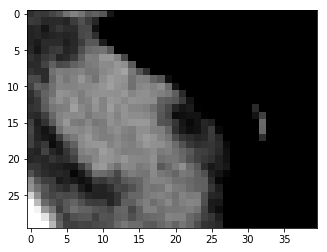

In [33]:
plt.imshow(roi[20], 'gray')

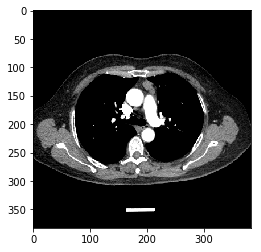

In [34]:
plt.imshow(gray_data[xmin + 20], 'gray')

In [35]:
def generate_gaussian_mask_np(mask_shape, gt_x, gt_y, gt_z, gt_h, gt_w, gt_d):
    H, W, D = mask_shape

#     xmin = max(0, gt_x - gt_h // 2)
#     xmax = min(gt_x + gt_h // 2 + 1, H)
#     ymin = max(0, gt_y - gt_w // 2)
#     ymax = min(gt_y + gt_w // 2 + 1, W)
#     zmin = max(0, gt_z - gt_d // 2)
#     zmax = min(gt_z + gt_d // 2 + 1, D)
#     h = range(xmin, xmax)
#     w = range(ymin, ymax)
#     d = range(zmin, zmax)
    h = range(H)
    w = range(W)
    d = range(D)

    [meshgrid_x, meshgrid_y, meshgrid_z] = np.meshgrid(h, w, d, indexing='ij')
    meshgrid_x = meshgrid_x.astype(np.float32)
    meshgrid_y = meshgrid_y.astype(np.float32)
    meshgrid_z = meshgrid_z.astype(np.float32)
    gt_y = np.reshape(gt_y, [-1, 1, 1]).astype(np.float32)
    gt_x = np.reshape(gt_x, [-1, 1, 1]).astype(np.float32)
    gt_z = np.reshape(gt_z, [-1, 1, 1]).astype(np.float32)
    
    sigma = compute_gaussian_radius(gt_h, gt_w, min_overlap=0.7)
    # print('sigma:', sigma, gt_h, gt_w)
    sigma = np.reshape(sigma, [-1, 1, 1]).astype(np.float32)
    gau = np.exp(-((gt_x - meshgrid_x) ** 2 + (gt_y - meshgrid_y) ** 2 + (gt_z - meshgrid_z) ** 2) / (2 * sigma ** 2))
    target = np.zeros(mask_shape)
    # print((xmin, xmax, ymin, ymax, zmin, zmax))
#     target[xmin:xmax, ymin:ymax, zmin:zmax] = gau
    return gau

In [36]:
def generate_gaussian_mask_tf(mask_shape, gt_x, gt_y, gt_z, gt_h, gt_w, gt_d):
    H, W, D = mask_shape

#     xmin = max(0, gt_x - gt_h // 2)
#     xmax = min(gt_x + gt_h // 2 + 1, H)
#     ymin = max(0, gt_y - gt_w // 2)
#     ymax = min(gt_y + gt_w // 2 + 1, W)
#     zmin = max(0, gt_z - gt_d // 2)
#     zmax = min(gt_z + gt_d // 2 + 1, D)
#     h = range(xmin, xmax)
#     w = range(ymin, ymax)
#     d = range(zmin, zmax)
    h = range(H)
    w = range(W)
    d = range(D)

    [meshgrid_x, meshgrid_y, meshgrid_z] = tf.meshgrid(h, w, d, indexing='ij')
    meshgrid_x = tf.cast(meshgrid_x, tf.float32)
    meshgrid_y = tf.cast(meshgrid_y, tf.float32)
    meshgrid_z = tf.cast(meshgrid_z, tf.float32)
    gt_y = tf.cast(tf.reshape(gt_y, [-1, 1, 1]), tf.float32)
    gt_x = tf.cast(tf.reshape(gt_x, [-1, 1, 1]), tf.float32)
    gt_z = tf.cast(tf.reshape(gt_z, [-1, 1, 1]), tf.float32)
    
#     print(gt_y, meshgrid_x)
    sigma = compute_gaussian_radius(gt_h, gt_w, min_overlap=0.7)
    # print('sigma:', sigma, gt_h, gt_w)
    sigma = tf.cast(tf.reshape(sigma, [-1, 1, 1]), tf.float32)
    gau = tf.exp(-((gt_x - meshgrid_x) ** 2 + (gt_y - meshgrid_y) ** 2 + (gt_z - meshgrid_z) ** 2) / (2 * sigma ** 2))
    target = tf.zeros(mask_shape)
    # print((xmin, xmax, ymin, ymax, zmin, zmax))
#     target[xmin:xmax, ymin:ymax, zmin:zmax] = gau
    return gau

In [33]:
tf.test.is_gpu_available()

True

In [38]:
t1 = time.time()
for i in range(100):
    res1 = generate_gaussian_mask_tf((192, 192, 192), 50, 50, 50, 25, 32, 29)
t2 = time.time()
print(t2-t1)

4.35869836807251


In [37]:
t1 = time.time()
for i in range(100):
    res = generate_gaussian_mask_np((192, 192, 192), 50, 50, 50, 25, 32, 29)
t2 = time.time()
print(t2-t1)

36.53299260139465


In [40]:
res1 = res1.numpy()

In [48]:
res[48, 50, 50]

0.76664585

In [12]:
res[50, 50, 100]

7.44297556562005e-73

In [20]:
gt_x, gt_y, gt_z, gt_h, gt_w, gt_d = 172, 133, 210, 30, 30, 39
xmin = gt_x - gt_h // 2
xmax = gt_x + gt_h // 2 + 1
ymin = gt_y - gt_w // 2
ymax = gt_y + gt_w // 2 + 1
zmin = gt_z - gt_d // 2
zmax = gt_z + gt_d // 2 + 1
h = range(xmin, xmax)
w = range(ymin, ymax)
d = range(zmin, zmax)
[meshgrid_x, meshgrid_y, meshgrid_z] = np.meshgrid(h, w, d, indexing='ij')

gt_y = np.reshape(gt_y, [-1, 1, 1])
gt_x = np.reshape(gt_x, [-1, 1, 1])
gt_z = np.reshape(gt_z, [-1, 1, 1])

sigma = 10
# print('sigma:', sigma)
sigma = np.reshape(sigma, [-1, 1, 1])
gau = np.exp(-((gt_x - meshgrid_x) ** 2 + (gt_y - meshgrid_y) ** 2 + (gt_z - meshgrid_z) ** 2) / (2 * sigma ** 2))
target = np.zeros(gray_data.shape)

In [15]:
gt_d // 2

19

In [21]:
gau.shape

(31, 31, 39)

In [22]:
target[xmin:xmax, ymin:ymax, zmin:zmax] = gau

In [24]:
target[gt_x, gt_y, gt_z]

array([[[1.]]])

In [19]:
gau[1, ...].shape

(30, 39)

In [12]:
gauss = generate_gaussian_mask_3d(gray_data.shape, 172, 133, 210, 30, 30, 39)

ValueError: operands could not be broadcast together with shapes (30,39) (300,383,383) 

In [38]:
gauss[172, 133, 210]

1.0

In [60]:
np.meshgrid(range(0,34), range(0,29), range(0,44), indexing='ij')

[array([[[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]],
 
        [[ 1,  1,  1, ...,  1,  1,  1],
         [ 1,  1,  1, ...,  1,  1,  1],
         [ 1,  1,  1, ...,  1,  1,  1],
         ...,
         [ 1,  1,  1, ...,  1,  1,  1],
         [ 1,  1,  1, ...,  1,  1,  1],
         [ 1,  1,  1, ...,  1,  1,  1]],
 
        [[ 2,  2,  2, ...,  2,  2,  2],
         [ 2,  2,  2, ...,  2,  2,  2],
         [ 2,  2,  2, ...,  2,  2,  2],
         ...,
         [ 2,  2,  2, ...,  2,  2,  2],
         [ 2,  2,  2, ...,  2,  2,  2],
         [ 2,  2,  2, ...,  2,  2,  2]],
 
        ...,
 
        [[31, 31, 31, ..., 31, 31, 31],
         [31, 31, 31, ..., 31, 31, 31],
         [31, 31, 31, ..., 31, 31, 31],
         ...,
         [31, 31, 31, ..., 31, 31, 31],
         [31, 31, 31, ..., 31, 31, 31],


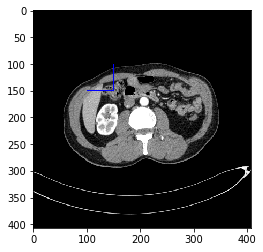

In [70]:
plt.imshow(cv2.rectangle(rgb_data, (100, 100), (150, 150), (0, 0, 255)))

In [ ]:
cv2.imshow('', rgb_data)
cv2.waitKey(0)

In [69]:
rgb_data = cv2.cvtColor(gray_data[0], cv2.COLOR_GRAY2BGR)

In [59]:
rgb_data.shape

(407, 407, 3)

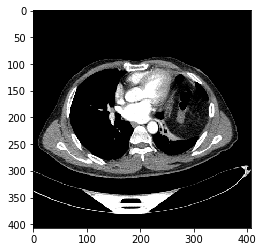

In [40]:
plt.imshow(gray_data[200], 'gray')

In [9]:
bboxs['id'] = bboxs['name'].apply(lambda x: '0' + str(int(x)))

In [7]:
data_names = ['0' + str(x) for x in bboxs.index.values]

In [8]:
len(data_names)

200

In [15]:
bboxs_list = []
for data_name in tqdm(data_names):
    raw_data = sitk.ReadImage(os.path.join(data_path, data_name, data_name + '.nii'))
    origin = np.array(raw_data.GetOrigin())
    spacing = np.array(raw_data.GetSpacing())
    bbox = read_bboxes(os.path.join(data_path, data_name, 'R.acsv'), org=origin, spacing=spacing)
    if len(bbox) == 1:
        bboxs_list.append(np.array(bbox[0]))
    else:
        print("errors")
#     np.save(os.path.join(data_path, data_name, data_name + '.npy'), new_data)
    

100%|██████████| 200/200 [05:50<00:00,  1.34s/it]


In [18]:
bboxs_list = np.array(bboxs_list)

In [19]:
bboxs_list

array([[367.        , 180.        , 119.        ,  60.1322496 ,
         62.7529728 ,  50.44389   ],
       [230.        , 200.        , 391.        ,  92.86640524,
        104.83552081, 143.95818957],
       [227.        , 195.        , 401.        ,  55.0090284 ,
         37.62275381,  48.45606751],
       ...,
       [216.        , 149.        , 179.        ,  78.1292544 ,
         74.883072  ,  61.719     ],
       [289.        , 174.        , 203.        ,  28.16194866,
         31.69325851,  22.3293    ],
       [234.        , 219.        , 155.        ,  84.40424642,
         89.69784058,  91.52178   ]])

In [47]:
# data_names
for data_name in tqdm(data_names):
    np_data = np.load(os.path.join(data_path, data_name, data_name + '.npy'))
    print(np_data.shape)
#     origin = np.array(raw_data.GetOrigin())
#     spacing = np.array(raw_data.GetSpacing())
#     bbox = read_bboxes(os.path.join(data_path, data_name, 'R.acsv'), org=origin, spacing=spacing)
#     if len(bbox) == 1:
#         bboxs_list.append(np.array(bbox[0]))
#     else:
#         print("errors")
#     np.save(os.path.join(data_path, data_name, data_name + '.npy'), new_data)
    

  0%|          | 1/200 [00:01<04:17,  1.29s/it]

(343, 350, 350)


  1%|          | 2/200 [00:03<04:41,  1.42s/it]

(359, 397, 397)


  2%|▏         | 3/200 [00:04<05:11,  1.58s/it]

(362, 407, 407)


  2%|▏         | 4/200 [00:06<04:54,  1.50s/it]

(304, 345, 345)


  2%|▎         | 5/200 [00:07<04:38,  1.43s/it]

(301, 363, 363)


  3%|▎         | 6/200 [00:08<04:27,  1.38s/it]

(300, 366, 366)


  4%|▎         | 7/200 [00:09<04:06,  1.28s/it]

(308, 327, 327)


  4%|▍         | 8/200 [00:11<04:04,  1.27s/it]

(300, 365, 365)


  4%|▍         | 9/200 [00:13<04:45,  1.50s/it]

(300, 450, 450)


  5%|▌         | 10/200 [00:14<04:25,  1.40s/it]

(287, 350, 350)


  6%|▌         | 11/200 [00:15<04:23,  1.39s/it]

(300, 383, 383)


  6%|▌         | 12/200 [00:17<04:20,  1.38s/it]

(349, 350, 350)


  6%|▋         | 13/200 [00:18<04:22,  1.41s/it]

(284, 400, 400)


  7%|▋         | 14/200 [00:20<04:38,  1.50s/it]

(352, 393, 393)


  8%|▊         | 15/200 [00:21<04:04,  1.32s/it]

(318, 300, 300)


  8%|▊         | 16/200 [00:22<04:26,  1.45s/it]

(406, 368, 368)


  8%|▊         | 17/200 [00:24<04:23,  1.44s/it]

(320, 350, 350)


  9%|▉         | 18/200 [00:25<04:27,  1.47s/it]

(326, 387, 387)


 10%|▉         | 19/200 [00:27<04:15,  1.41s/it]

(278, 378, 378)


 10%|█         | 20/200 [00:28<04:23,  1.47s/it]

(300, 404, 404)


 10%|█         | 21/200 [00:29<04:01,  1.35s/it]

(280, 348, 348)


 11%|█         | 22/200 [00:30<03:48,  1.29s/it]

(299, 350, 350)


 12%|█▏        | 23/200 [00:32<04:28,  1.52s/it]

(360, 410, 410)


 12%|█▏        | 24/200 [00:34<04:09,  1.42s/it]

(300, 352, 352)


 12%|█▎        | 25/200 [00:35<03:58,  1.36s/it]

(224, 376, 376)


 13%|█▎        | 26/200 [00:36<03:44,  1.29s/it]

(300, 348, 348)


 14%|█▎        | 27/200 [00:37<03:42,  1.29s/it]

(333, 351, 351)


 14%|█▍        | 28/200 [00:39<03:46,  1.32s/it]

(316, 370, 370)


 14%|█▍        | 29/200 [00:40<03:49,  1.34s/it]

(300, 388, 388)


 15%|█▌        | 30/200 [00:42<04:29,  1.58s/it]

(363, 428, 428)


 16%|█▌        | 31/200 [00:44<04:13,  1.50s/it]

(261, 399, 399)


 16%|█▌        | 32/200 [00:45<04:32,  1.62s/it]

(300, 451, 451)


 16%|█▋        | 33/200 [00:47<04:08,  1.49s/it]

(326, 326, 326)


 17%|█▋        | 34/200 [00:48<03:38,  1.31s/it]

(320, 300, 300)


 18%|█▊        | 35/200 [00:49<03:43,  1.36s/it]

(401, 342, 342)


 18%|█▊        | 36/200 [00:50<03:27,  1.26s/it]

(319, 326, 326)


 18%|█▊        | 37/200 [00:52<03:45,  1.38s/it]

(336, 396, 396)


 19%|█▉        | 38/200 [00:53<04:04,  1.51s/it]

(348, 393, 393)


 20%|█▉        | 39/200 [00:55<04:14,  1.58s/it]

(374, 381, 381)


 20%|██        | 40/200 [00:57<04:05,  1.53s/it]

(300, 387, 387)


 20%|██        | 41/200 [00:58<04:11,  1.58s/it]

(332, 383, 383)


 21%|██        | 42/200 [01:00<03:57,  1.51s/it]

(359, 344, 344)


 22%|██▏       | 43/200 [01:01<04:10,  1.60s/it]

(340, 415, 415)


 22%|██▏       | 44/200 [01:03<04:10,  1.61s/it]

(400, 363, 363)


 22%|██▎       | 45/200 [01:05<04:19,  1.67s/it]

(361, 400, 400)


 23%|██▎       | 46/200 [01:06<03:51,  1.50s/it]

(291, 350, 350)


 24%|██▎       | 47/200 [01:08<04:29,  1.76s/it]

(375, 443, 443)


 24%|██▍       | 48/200 [01:09<03:56,  1.56s/it]

(315, 329, 329)


 24%|██▍       | 49/200 [01:11<03:41,  1.47s/it]

(328, 347, 347)


 25%|██▌       | 50/200 [01:12<03:49,  1.53s/it]

(335, 400, 400)


 26%|██▌       | 51/200 [01:14<03:41,  1.49s/it]

(332, 350, 350)


 26%|██▌       | 52/200 [01:15<03:27,  1.40s/it]

(347, 329, 329)


 26%|██▋       | 53/200 [01:17<03:39,  1.49s/it]

(364, 385, 385)


 27%|██▋       | 54/200 [01:19<04:26,  1.83s/it]

(417, 437, 437)


 28%|██▊       | 55/200 [01:21<04:25,  1.83s/it]

(365, 402, 402)


 28%|██▊       | 56/200 [01:22<03:50,  1.60s/it]

(348, 311, 311)


 28%|██▊       | 57/200 [01:24<03:36,  1.51s/it]

(329, 342, 342)


 29%|██▉       | 58/200 [01:25<03:29,  1.47s/it]

(351, 350, 350)


 30%|██▉       | 59/200 [01:26<03:09,  1.34s/it]

(250, 360, 360)


 30%|███       | 60/200 [01:27<02:54,  1.24s/it]

(300, 324, 324)


 30%|███       | 61/200 [01:28<03:03,  1.32s/it]

(313, 369, 369)


 31%|███       | 62/200 [01:30<03:00,  1.31s/it]

(349, 333, 333)


 32%|███▏      | 63/200 [01:31<03:05,  1.35s/it]

(277, 406, 406)


 32%|███▏      | 64/200 [01:32<02:39,  1.17s/it]

(239, 316, 316)


 32%|███▎      | 65/200 [01:33<02:27,  1.09s/it]

(315, 300, 300)


 33%|███▎      | 66/200 [01:34<02:30,  1.12s/it]

(300, 343, 343)


 34%|███▎      | 67/200 [01:36<02:47,  1.26s/it]

(394, 360, 360)


 34%|███▍      | 68/200 [01:37<02:51,  1.30s/it]

(352, 350, 350)


 34%|███▍      | 69/200 [01:39<03:22,  1.54s/it]

(381, 407, 407)


 35%|███▌      | 70/200 [01:41<03:26,  1.59s/it]

(357, 384, 384)


 36%|███▌      | 71/200 [01:42<02:55,  1.36s/it]

(282, 300, 300)


 36%|███▌      | 72/200 [01:43<02:47,  1.31s/it]

(300, 358, 358)


 36%|███▋      | 73/200 [01:45<03:20,  1.58s/it]

(324, 453, 453)


 37%|███▋      | 74/200 [01:46<03:02,  1.45s/it]

(284, 349, 349)


 38%|███▊      | 75/200 [01:48<02:56,  1.41s/it]

(336, 350, 350)


 38%|███▊      | 76/200 [01:50<03:19,  1.61s/it]

(331, 437, 437)


 38%|███▊      | 77/200 [01:51<03:09,  1.54s/it]

(270, 396, 396)


 39%|███▉      | 78/200 [01:52<03:04,  1.52s/it]

(304, 392, 392)


 40%|███▉      | 79/200 [01:54<03:10,  1.58s/it]

(300, 405, 405)


 40%|████      | 80/200 [01:55<02:49,  1.42s/it]

(271, 350, 350)


 40%|████      | 81/200 [01:56<02:28,  1.25s/it]

(300, 300, 300)


 41%|████      | 82/200 [01:58<02:55,  1.49s/it]

(342, 380, 380)


 42%|████▏     | 83/200 [02:00<02:52,  1.47s/it]

(340, 366, 366)


KeyboardInterrupt: 

In [5]:
data_names = os.listdir(data_path)

In [7]:
data_names[0]

'0707757'

In [22]:
annofile = glob.glob(os.path.join(data_path, data_name, '*.acsv'))

In [23]:
annofile

['/home/jxw/Downloads/mediastinal_1/annoation/0732826/R.acsv']

In [27]:
new_size = np.array([128, 128, 128])
results = {}
# new_spacing = [1.0, 1.0, 1.0]
# new_bboxs = []
for data_name in tqdm(data_names):
    raw_data = sitk.ReadImage(os.path.join(data_path, data_name, data_name + '.nii'))
    np_data_name = os.path.join(data_path, data_name, data_name + '_128.npy')
    if not os.path.exists(np_data_name):
        np_data = sitk.GetArrayFromImage(raw_data)
        new_data = resize(np_data, new_size)
        np.save(os.path.join(data_path, data_name, data_name + '_128.npy'), new_data)
    origin = np.array(raw_data.GetOrigin())
    spacing = np.array(raw_data.GetSpacing())
    annofile = glob.glob(os.path.join(data_path, data_name, '*.acsv'))
    if len(annofile) > 0:
        bbox = read_bboxes(annofile[0], org=origin, spacing=spacing)
    else:
        print(data_name)
        continue
    new_bbox = scale2newspacing(bbox, org_spacing=new_size, new_spacing=np.array(raw_data.GetSize()))
    if len(new_bbox) == 1:
        results[data_name] = {
            'x': new_bbox[0][2],
            'y': new_bbox[0][1],
            'z': new_bbox[0][0],
            'w': new_bbox[0][5],
            'h': new_bbox[0][4], 
            'd': new_bbox[0][3],
        }
    else:
        print(data_name, "errors")
    
#     break





  0%|          | 0/937 [00:00<?, ?it/s]



  0%|          | 1/937 [00:00<02:52,  5.41it/s]



  0%|          | 2/937 [00:00<03:11,  4.88it/s]



  0%|          | 3/937 [00:00<03:21,  4.63it/s]



  0%|          | 4/937 [00:00<03:34,  4.34it/s]



  1%|          | 5/937 [00:01<03:35,  4.33it/s]



  1%|          | 6/937 [00:01<03:26,  4.51it/s]



  1%|          | 7/937 [00:01<03:19,  4.66it/s]



  1%|          | 8/937 [00:01<03:41,  4.19it/s]



  1%|          | 9/937 [00:02<03:59,  3.88it/s]



  1%|          | 10/937 [00:02<04:03,  3.81it/s]



  1%|          | 11/937 [00:02<04:06,  3.76it/s]



  1%|▏         | 12/937 [00:04<12:44,  1.21it/s]



  1%|▏         | 13/937 [00:06<15:56,  1.03s/it]



  1%|▏         | 14/937 [00:08<19:43,  1.28s/it]



  2%|▏         | 15/937 [00:09<20:51,  1.36s/it]



  2%|▏         | 16/937 [00:12<25:46,  1.68s/it]



  2%|▏         | 17/937 [00:13<23:16,  1.52s/it]



  2%|▏         | 18/937 [00:13<18:00,  1.18s/it]



  2%|▏         | 19/937 [0

 27%|██▋       | 253/937 [07:29<23:22,  2.05s/it]



 27%|██▋       | 254/937 [07:30<17:22,  1.53s/it]



 27%|██▋       | 255/937 [07:31<18:29,  1.63s/it]



 27%|██▋       | 256/937 [07:34<20:36,  1.82s/it]



 27%|██▋       | 257/937 [07:35<17:52,  1.58s/it]



 28%|██▊       | 258/937 [07:37<19:06,  1.69s/it]



 28%|██▊       | 259/937 [07:39<19:25,  1.72s/it]



 28%|██▊       | 260/937 [07:40<19:13,  1.70s/it]



 28%|██▊       | 261/937 [07:43<21:43,  1.93s/it]



 28%|██▊       | 262/937 [07:44<21:00,  1.87s/it]



 28%|██▊       | 263/937 [07:46<20:07,  1.79s/it]



 28%|██▊       | 264/937 [07:48<21:36,  1.93s/it]



 28%|██▊       | 265/937 [07:50<22:19,  1.99s/it]



 28%|██▊       | 266/937 [07:52<21:19,  1.91s/it]



 28%|██▊       | 267/937 [07:55<24:13,  2.17s/it]



 29%|██▊       | 268/937 [07:57<23:12,  2.08s/it]



 29%|██▊       | 269/937 [07:58<21:36,  1.94s/it]



 29%|██▉       | 270/937 [07:59<18:52,  1.70s/it]



 29%|██▉       | 271/937 [08:02<20:08,  1.81s/

0356324






 34%|███▍      | 323/937 [09:43<18:26,  1.80s/it]



 35%|███▍      | 324/937 [09:45<17:38,  1.73s/it]



 35%|███▍      | 325/937 [09:47<18:33,  1.82s/it]



 35%|███▍      | 326/937 [09:49<19:35,  1.92s/it]



 35%|███▍      | 327/937 [09:50<17:36,  1.73s/it]



 35%|███▌      | 328/937 [09:51<16:00,  1.58s/it]



 35%|███▌      | 329/937 [09:53<16:00,  1.58s/it]



 35%|███▌      | 330/937 [09:55<16:27,  1.63s/it]



 35%|███▌      | 331/937 [09:56<16:17,  1.61s/it]



 35%|███▌      | 332/937 [09:58<17:26,  1.73s/it]



 36%|███▌      | 333/937 [09:59<16:16,  1.62s/it]



 36%|███▌      | 334/937 [10:01<14:54,  1.48s/it]



 36%|███▌      | 335/937 [10:02<15:09,  1.51s/it]



 36%|███▌      | 336/937 [10:04<17:16,  1.72s/it]



 36%|███▌      | 337/937 [10:07<19:20,  1.93s/it]



 36%|███▌      | 338/937 [10:09<20:48,  2.08s/it]



 36%|███▌      | 339/937 [10:11<18:42,  1.88s/it]



 36%|███▋      | 340/937 [10:13<18:29,  1.86s/it]



 36%|███▋      | 341/937 [10:14<17:44,  1.

 48%|████▊     | 449/937 [14:05<23:11,  2.85s/it]



 48%|████▊     | 450/937 [14:07<20:30,  2.53s/it]



 48%|████▊     | 451/937 [14:08<17:54,  2.21s/it]



 48%|████▊     | 452/937 [14:10<16:42,  2.07s/it]



 48%|████▊     | 453/937 [14:12<16:36,  2.06s/it]



 48%|████▊     | 454/937 [14:14<16:34,  2.06s/it]



 49%|████▊     | 455/937 [14:16<14:49,  1.85s/it]



 49%|████▊     | 456/937 [14:18<16:33,  2.07s/it]



 49%|████▉     | 457/937 [14:20<16:56,  2.12s/it]



 49%|████▉     | 458/937 [14:23<17:20,  2.17s/it]



 49%|████▉     | 459/937 [14:25<16:31,  2.08s/it]



 49%|████▉     | 460/937 [14:27<16:22,  2.06s/it]



 49%|████▉     | 461/937 [14:28<15:07,  1.91s/it]



 49%|████▉     | 462/937 [14:30<15:30,  1.96s/it]



 49%|████▉     | 463/937 [14:33<16:52,  2.14s/it]



 50%|████▉     | 464/937 [14:36<19:44,  2.50s/it]



 50%|████▉     | 465/937 [14:38<19:10,  2.44s/it]



 50%|████▉     | 466/937 [14:40<17:08,  2.18s/it]



 50%|████▉     | 467/937 [14:42<16:03,  2.05s/

 75%|███████▍  | 701/937 [22:11<08:47,  2.24s/it]



 75%|███████▍  | 702/937 [22:15<09:55,  2.54s/it]



 75%|███████▌  | 703/937 [22:16<08:24,  2.15s/it]



 75%|███████▌  | 704/937 [22:17<07:38,  1.97s/it]



 75%|███████▌  | 705/937 [22:19<07:21,  1.90s/it]



 75%|███████▌  | 706/937 [22:22<07:57,  2.07s/it]



 75%|███████▌  | 707/937 [22:24<08:09,  2.13s/it]



 76%|███████▌  | 708/937 [22:26<07:58,  2.09s/it]



 76%|███████▌  | 709/937 [22:27<06:58,  1.83s/it]



 76%|███████▌  | 710/937 [22:29<07:01,  1.86s/it]



 76%|███████▌  | 711/937 [22:31<06:46,  1.80s/it]



 76%|███████▌  | 712/937 [22:33<06:51,  1.83s/it]



 76%|███████▌  | 713/937 [22:34<06:51,  1.84s/it]



 76%|███████▌  | 714/937 [22:36<06:20,  1.71s/it]



 76%|███████▋  | 715/937 [22:38<06:49,  1.84s/it]



 76%|███████▋  | 716/937 [22:40<07:03,  1.91s/it]



 77%|███████▋  | 717/937 [22:41<06:09,  1.68s/it]



 77%|███████▋  | 718/937 [22:43<06:38,  1.82s/it]



 77%|███████▋  | 719/937 [22:45<06:56,  1.91s/

In [42]:
with open(os.path.join(data_path, 'annoation_128.json'), 'w') as f:
    json.dump(results, f)

In [2]:
[] + [['0356324', 'sdsd']] + [['2', '12']]

[['0356324', 'sdsd'], ['2', '12']]

In [30]:
len(results.keys())

936

In [13]:
len(new_bboxs)

332

In [19]:
os.path.exists(os.path.join(data_path, '*.acsv'))

False

In [15]:
bboxs_list = np.array(new_bboxs)

In [23]:
data_names[0]

'0271871'

In [24]:
roi = new_data[52:80, 56:79, 126:148]

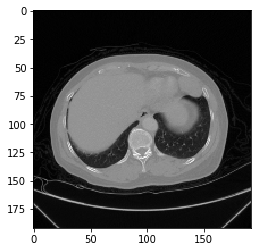

In [30]:
plt.imshow(new_data[66], 'gray')

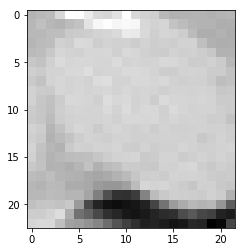

In [29]:
plt.imshow(roi[14], 'gray')

In [10]:
new_spacing = [1.0, 1.0, 1.0]
bboxs = []
for data_name in tqdm(data_names):
    raw_data = sitk.ReadImage(os.path.join(data_path, data_name, data_name + '.nii'))
    np_data = sitk.GetArrayFromImage(raw_data)
    origin = np.array(raw_data.GetOrigin())
    spacing = np.array(raw_data.GetSpacing())
    bbox = read_bboxes(os.path.join(data_path, data_name, 'R.acsv'), org=origin, spacing=spacing)
    new_data = interpolate_volume(np_data, spacing, new_spacing)
    new_bbox = scale2newspacing(bbox, org_spacing=spacing, new_spacing=new_spacing)
    if len(new_bbox) == 1:
        bboxs.append(np.array(new_bbox[0]))
    else:
        print("errors")
    np.save(os.path.join(data_path, data_name, data_name + '.npy'), new_data)
    

  0%|          | 1/201 [00:04<13:31,  4.06s/it]


SystemError: <built-in function ReadImage> returned a result with an error set

In [33]:
bboxs = np.array(bboxs)

In [17]:
bboxs_list.shape

(933, 6)

In [21]:
len(bboxs_list[:, 4])

933

In [16]:
df = pd.DataFrame({
    'name': data_names,
    'x': bboxs_list[:, 2],
    'y': bboxs_list[:, 1],
    'z': bboxs_list[:, 0],
    'w': bboxs_list[:, 5],
    'h': bboxs_list[:, 4], 
    'd': bboxs_list[:, 3],
})

ValueError: arrays must all be same length

In [ ]:
df = df.set_index('name')

In [19]:
df['train'] = list(bboxs['train'])

In [ ]:
df.to_csv(os.path.join(data_path, 'annoation_128.csv'), index='name')

In [20]:
df[df['train'] == 0]

,x,y,z,w,h,d,train
name,,,,,,,
687467,89.200000,52.25,59.75,10.885140,6.779412,11.322547,0
569302,83.596899,43.25,76.50,40.177681,34.326970,27.505229,0
495604,61.953092,53.25,42.75,36.680066,40.178318,33.918145,0
317880,101.253731,76.00,52.50,24.111841,20.418048,19.744906,0
629808,80.592593,36.75,60.25,12.470559,11.859686,10.215398,0
325193,92.595745,52.25,60.50,12.627893,6.599704,5.330406,0
461712,82.285714,44.00,64.50,13.902741,9.514258,10.527010,0
758456,78.492986,43.50,61.50,17.725716,15.623590,20.218759,0
568347,89.032755,47.00,69.50,21.165726,21.792554,21.189906,0


In [21]:
bboxs[bboxs['train'] == 0]

,x,y,z,w,h,d,train
name,,,,,,,
687467,223.000000,142.871094,163.378906,27.21285,18.537456,30.960090,0
569302,235.904114,135.156250,239.062500,113.37837,107.271780,85.953840,0
495604,158.900173,144.357422,115.892578,94.07874,108.920910,91.949970,0
317880,265.000000,237.500000,164.062500,63.10521,63.806400,61.702830,0
629808,221.000000,100.488281,164.746094,34.19661,32.428830,27.932730,0
325193,217.599792,162.056641,187.644531,29.67552,20.469393,16.532586,0
461712,220.499039,124.437500,182.414062,37.25484,26.907510,29.771700,0
758456,214.203735,111.468750,157.593750,48.37266,40.035450,51.810570,0
568347,252.704407,139.898438,206.871094,60.07533,64.866900,63.073080,0


In [23]:
pd.read_csv(os.path.join(data_path, 'annoation_128.csv'), index_col='name')

,x,y,z,w,h,d,train
name,,,,,,,
271871,44.408163,45.00,91.75,18.824542,15.688243,15.033062,1
591127,97.369650,50.00,57.50,35.849510,26.208880,23.216601,1
561675,99.088803,48.75,56.75,11.973700,9.405688,13.752257,1
594243,87.098851,45.00,59.00,9.686058,9.511157,10.109373,1
776465,95.681063,43.75,68.50,15.253820,11.284268,11.047976,1
638924,96.969697,55.25,80.75,23.098585,22.056876,21.045938,1
491901,89.977324,44.75,69.75,17.838053,11.612900,14.738296,1
365210,79.365967,45.25,59.00,19.215419,10.371703,13.670652,1
463753,78.172494,54.75,78.25,18.094409,12.660122,7.811806,1


In [32]:
.shape

(200, 6)

In [6]:
data_name = data_names[10]
raw_data = sitk.ReadImage(os.path.join(data_path, data_name, data_name + '.nii'))
np_data = sitk.GetArrayFromImage(raw_data)

In [7]:
origin = np.array(raw_data.GetOrigin())
spacing = np.array(raw_data.GetSpacing())

In [8]:
bbox = read_bboxes(os.path.join(data_path, data_name, 'R.acsv'), org=origin, spacing=spacing)

In [21]:
bbox[0]

[281, 179, 246, 52.9363350391645, 40.20883049608356, 43.790236358880456]

In [22]:
scale2newspacing(bbox, org_spacing=spacing, new_spacing=new_spacing)

[[210.201171875,
  133.900390625,
  172.2030029296875,
  39.59886,
  30.078090000000003,
  30.653699999999997]]

In [9]:
new_spacing = [1.0, 1.0, 1.0]

In [16]:
np_data.shape

(429, 512, 512)

In [15]:
spacing

array([0.74804688, 0.74804688, 0.70001221])

In [11]:
new_data = interpolate_volume(np_data, spacing, new_spacing)

In [26]:
new_data.shape

(300, 383, 383)

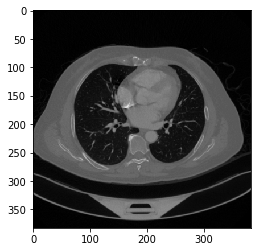

In [28]:
plt.imshow(new_data[130], 'gray')

In [12]:
raw_data.GetOrigin()[0]

-187.1259765625

In [ ]:
def getMidPoint(worldPoint, origin, spacing):
    x = abs(worldPoint[0] + origin[0]) / spacing[0]
    y = abs(worldPoint[1] + origin[1]) / spacing[1]
    z = abs(worldPoint[2] - origin[2]) / spacing[2]
    return (int(x), int(y), int(z))

In [10]:
data_name

'0432631'

In [9]:
np_data = sitk.GetArrayFromImage(raw_data)
print(np_data.shape)

(429, 512, 512)


In [10]:
data_resized = resize(np_data, (96, 128, 128))

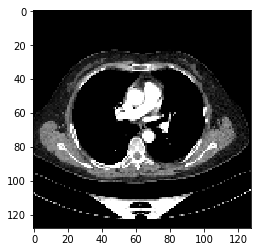

In [52]:
plt.imshow(data_resized[50], 'gray')

In [11]:
data_resized = hu2gray(data_resized)

In [16]:
np_data = sitk.GetArrayFromImage(raw_data)

In [17]:
np_data.shape

(518, 512, 512)

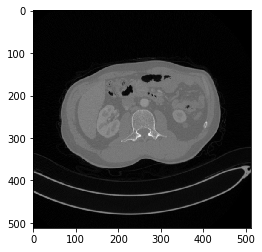

In [18]:
plt.imshow(np_data[19], 'gray')

In [3]:
label = pd.read_excel(label_file)

In [9]:
label

,ID,label_1,label_2
0,237983,1,31
1,248469,0,15
2,249306,1,1
3,254546,0,8
4,255426,1,31
5,255491,0,11
6,258576,1,31
7,259933,0,5
8,261263,0,20
9,263833,1,1


In [7]:
ID = list(label['ID'])

In [10]:
labels = list(label['label_1'])

In [15]:
ID = list(map(lambda x: '%07d' % x, ID))

In [16]:
ID[-1]

'1088167'

In [17]:
len(label)

937

In [37]:
np.random.choice([1 , 3 ,4 ,5 ,2 ,3, 4, 0], 5, replace=False)

array([4, 4, 3, 0, 1])

In [59]:
i = 1
for x in np.arange(3, 20):
    print(i, (x - i) ** 3 / (2 *x**3 -  (x-i)**3))


1 0.17391304347826086
1 0.26732673267326734
1 0.34408602150537637
1 0.40716612377850164
1 0.4595744680851064
1 0.5036710719530103
1 0.5412262156448203
1 0.5735641227380016
1 0.601684717208183
1 0.6263529411764706
1 0.6481620405101275
1 0.6675782436949256
1 0.6849725411882177
1 0.7006435540793025
1 0.7148342059336824
1 0.7277440379203081
1 0.7395384225209232


In [30]:
9**3 / (2 * 10**3 - 9**3)

0.5735641227380016

In [31]:
9**3

729

In [32]:
10**3

1000

In [33]:
81/(200-81)

0.680672268907563

In [38]:
[1] * 10

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [39]:
idx = np.arange(0, 100)

In [40]:
np.random.shuffle(idx)

In [41]:
idx

array([43, 95, 89, 67, 28, 49, 42, 52,  7, 61, 82, 17, 62, 24, 91, 69, 54,
       39, 66, 47, 74, 86,  3, 59, 75, 57, 98, 85, 58, 36, 77,  5, 19, 50,
       90, 64, 31, 99, 38, 84, 72, 87, 51, 33, 32, 70, 76, 48, 20,  6, 73,
        0,  1, 12, 21, 29,  8, 55, 40, 83, 11, 35, 94, 88, 26, 80,  4, 13,
        9, 30, 18, 93, 15, 14, 92, 63, 56, 81, 96, 53, 65, 79, 22, 46, 34,
        2, 71, 25, 45, 23, 78, 27, 10, 37, 41, 97, 44, 68, 60, 16])

In [42]:
idx + [0]

array([43, 95, 89, 67, 28, 49, 42, 52,  7, 61, 82, 17, 62, 24, 91, 69, 54,
       39, 66, 47, 74, 86,  3, 59, 75, 57, 98, 85, 58, 36, 77,  5, 19, 50,
       90, 64, 31, 99, 38, 84, 72, 87, 51, 33, 32, 70, 76, 48, 20,  6, 73,
        0,  1, 12, 21, 29,  8, 55, 40, 83, 11, 35, 94, 88, 26, 80,  4, 13,
        9, 30, 18, 93, 15, 14, 92, 63, 56, 81, 96, 53, 65, 79, 22, 46, 34,
        2, 71, 25, 45, 23, 78, 27, 10, 37, 41, 97, 44, 68, 60, 16])

In [43]:
import math

In [47]:
math.ceil(36 / 6)

6

In [49]:
np.random.randint(-3, 3, (3, 2))

array([[ 0,  2],
       [-2, -3],
       [ 2, -1]])

In [50]:
a = np.array([[0, 1, 3], [4, 2, 1]])

In [52]:
b = a.copy()

In [53]:
b[:, :2] += np.random.randint(-2, 3, (2, 2))

In [54]:
b

array([[2, 2, 3],
       [6, 0, 1]])

In [55]:
a

array([[0, 1, 3],
       [4, 2, 1]])

In [56]:
np.vstack((a, b))

array([[0, 1, 3],
       [4, 2, 1],
       [2, 2, 3],
       [6, 0, 1]])

In [60]:
14/18

0.7777777777777778

In [62]:
for x in range(3, 20):
    print(x, (x - 2) ** 3 / x**3)

3 0.037037037037037035
4 0.125
5 0.216
6 0.2962962962962963
7 0.36443148688046645
8 0.421875
9 0.47050754458161864
10 0.512
11 0.5477084898572502
12 0.5787037037037037
13 0.6058261265361857
14 0.6297376093294461
15 0.650962962962963
16 0.669921875
17 0.6869529818847955
18 0.7023319615912208
19 0.7162851727657092


In [63]:
mode = 998244353

In [65]:
1024 * 1024 % 5

1

In [31]:
a = np.array([1000, -2000, 2000], dtype=np.int16)

In [13]:
import sys

In [14]:
sys.getsizeof(a)

102

In [15]:
a

array([ 1000, -2000,  2000], dtype=int16)

In [20]:
7 * 4 * 21000 +2 * 7 * 20000 + (100-42) * 10000

1448000

In [21]:
a = np.array([[0, 2, 3], [1, 2, 4]])

In [23]:
np.pad(a, ((1, 2), (3, 2)), 'edge').shape

(5, 8)

In [24]:
True == 1

True

In [30]:
np.append(a, 0)

array([0.])

In [28]:
a = np.array([])

In [33]:
np.where(a > 0)[0]

array([0, 2])

In [34]:
b = a[:3]

In [36]:
len(b)

3

In [37]:
np.append(a, b)

array([ 1000, -2000,  2000,  1000, -2000,  2000], dtype=int16)

In [4]:
results_file = './results/train_results.json'
with open(results_file, 'r') as f:
    train_res = json.load(f)

In [5]:
results_file = './results/test_results.json'
with open(results_file, 'r') as f:
    test_res = json.load(f)

In [6]:
test_res

{'0411079': {'bbox_gt': [88.0, 35.0, 67.0, 38.0, 27.0, 28.0],
  'bbox_pred': [[85, 34, 69, 31, 25, 26],
   [81, 60, 62, 11, 5, 7],
   [48, 46, 54, 11, 13, 9],
   [29, 45, 89, 10, 13, 17],
   [60, 15, 98, 18, 17, 15],
   [3, 71, 58, 10, 12, 14],
   [84, 33, 18, 37, 25, 24],
   [127, 40, 3, 13, 6, 14],
   [81, 42, 52, 9, 5, 11],
   [23, 65, 71, 13, 11, 17],
   [69, 52, 46, 12, 4, 7],
   [90, 34, 17, 36, 20, 23],
   [28, 24, 88, 21, 9, -1],
   [127, 39, 0, 4, 4, 15],
   [42, 70, 53, 11, 8, 10]],
  'score': [0.5333492159843445,
   0.18772315979003906,
   0.18687719106674194,
   0.01702868938446045,
   0.014813750982284546,
   0.0144520103931427,
   0.013798266649246216,
   0.013658910989761353,
   0.013151198625564575,
   0.012798160314559937,
   0.012398451566696167,
   0.012331277132034302,
   0.011776745319366455,
   0.010996133089065552,
   0.010329127311706543],
  'bbox_pred_raw': [[0.668870210647583,
    0.39453125,
    0.541015625,
    0.2421875,
    0.1953125,
    0.203125],
   [0.

In [7]:
DATA_ROOT = '/home/jxw/Downloads/mediastinal_1/annoation/'

In [8]:
bbox_size = []
for name in tqdm(train_res.keys()):
    data = np.load(os.path.join(DATA_ROOT, name, name + '_.npy'))
    bbox = np.array(train_res[name]['bbox_gt_raw'])[3:] * np.array(data.shape)
#     print(bbox)
    bbox_size.append(bbox)

100%|██████████| 916/916 [16:15<00:00,  1.06it/s]


In [9]:
for name in tqdm(test_res.keys()):
    data = np.load(os.path.join(DATA_ROOT, name, name + '_.npy'))
    bbox = np.array(test_res[name]['bbox_gt_raw'])[3:] * np.array(data.shape)
#     print(bbox)
    bbox_size.append(bbox)

100%|██████████| 20/20 [00:23<00:00,  1.07s/it]


In [12]:
bbox = np.array(bbox_size)

In [13]:
bbox.shape

(936, 3)

In [14]:
from sklearn.cluster import KMeans

In [28]:
km = KMeans(n_clusters=5)

In [29]:
res = km.fit_predict(bbox)

In [30]:
for i in range(0, np.max(res)+1):
    print(i, np.sum(res==i), np.mean(bbox[res==i], axis=0))

0 403 [27.72486494 23.50093763 23.17589447]
1 63 [109.25313095  95.50861667  92.81211333]
2 274 [48.13617552 42.57668682 42.49893624]
3 24 [162.1810308  144.29534875 129.97793375]
4 172 [72.76760311 63.93123035 63.76401419]
